# <i class="fa-solid fa-arrows-to-dot"></i> K-Nearest Neighbors

The k-Nearest Neighbours (kNN) algorithm is one of the simplest and most intuitive methods for classification and regression tasks. It is a non-parametric, instance-based learning algorithm, which means it makes predictions based on the similarity of new instances to previously encountered data points, without assuming any specific distribution for the underlying data. The idea behind kNN is straightforward: to classify a new data point, the algorithm finds the k closest points in the training set (its 'neighbours') and assigns the most common class among those neighbours to the new instance. In the case of regression, the prediction is the average of the values of its nearest neighbours.

We often evaluate kNN classification using the  error rate the (proportion of misclassified observations). Here, the choice of $k$ is crucial for the algorithm's performance. A small $k$ (e.g., $k=1$) makes the classifier sensitive to noise, while a large $k$ may smooth out boundaries too much, leading to underfitting. Typically, $k$ is chosen through cross-validation to optimise predictive accuracy. 

Have a look at the folloqing plot, which illustrates the conceptwith two clearly defined classes. The blue dot in the center represents a new datapoint, which we wish to classify depending on other data points, which are already labeled (Class A and B). To determine its class, we calculate the distance from this point to every point in both Class A and Class B. The dashed circle around the new example marks the radius up to the fifth-nearest neighbour, demonstrating the boundary within which the algorithm searches for its neighbours.

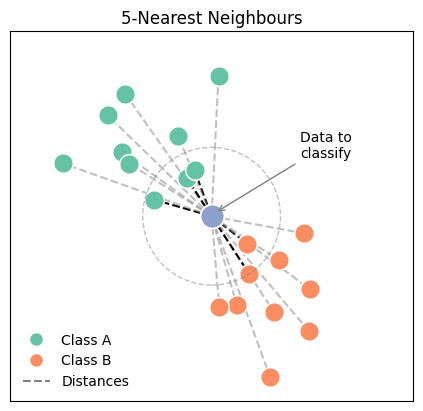

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

np.random.seed(123)
palette = sns.color_palette("Set2", 3)

class_a = np.random.randn(10, 2) + [-2, 2]
class_b = np.random.randn(10, 2) + [2, -2]

new_example = np.array([[0, 0]])
distances = np.vstack([class_a, class_b])

# Distances
euclidean_distances = np.sqrt(((distances - new_example) ** 2).sum(axis=1))
sorted_indices = np.argsort(euclidean_distances)
nearest_indices = sorted_indices[:5]
radius = euclidean_distances[nearest_indices[-1]]

# Data points
sns.scatterplot(x=class_a[:, 0], y=class_a[:, 1], color=palette[0], s=200, label='Class A')
sns.scatterplot(x=class_b[:, 0], y=class_b[:, 1], color=palette[1], s=200, label='Class B')
sns.scatterplot(x=new_example[:, 0], y=new_example[:, 1], color=palette[2], s=300)

# Annotate
plt.annotate("Data to\nclassify", (0.1, 0.1), textcoords="offset points", xytext=(80, 40), ha='center',
             arrowprops=dict(arrowstyle='->', color='grey'))

# Lines
for i, point in enumerate(distances):
    color = 'black' if i in nearest_indices else 'grey'
    alpha = 1 if i in nearest_indices else 0.5
    plt.plot([new_example[0, 0], point[0]], [new_example[0, 1], point[1]], linestyle='--', color=color, alpha=alpha, zorder=-1)

# Decision boundary
circle = plt.Circle((0, 0), radius, color='grey', linestyle='--', fill=False, alpha=0.5)
plt.gca().add_artist(circle)
plt.gca().set_aspect('equal', adjustable='box')

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Class A', markerfacecolor=palette[0], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Class B', markerfacecolor=palette[1], markersize=10),
    Line2D([0], [0], linestyle='--', color='grey', label='Distances')
]

plt.xlim(-6,6)
plt.ylim(-5.5,5.5)
plt.xticks([], [])
plt.yticks([], [])
plt.legend(handles=legend_elements, loc="lower left", frameon=False)
plt.title("5-Nearest Neighbours")
plt.show()

In an algorithmic description, this includes the following steps:

**Step 1: Neighbour Identification**  
Given a positive integer $k$ and an observation $x_0$, the kNN classifier first identifies the $k$ points in the training data that are closest to $x_0$, represented by the set $N_0$.

**Step 2: Conditional Probability Estimation**  
The classifier then estimates the conditional probability for class $j$ as the fraction of points in $N_0$ whose response values equal $j$:

$$P(Y = j \mid X = x_0) = \frac{1}{k} \sum_{i \in N_0} I(y_i = j)$$

where:
- $I(y_i = j)$ is an indicator function that equals 1 if the label of the neighbour $y_i$ is class $j$, and 0 otherwise.
- $k$ is the number of neighbours considered.
- $N_0$ is the set of the $k$ nearest neighbours to $x_0$.

**Step 3: Classification Decision**  
Finally, the test observation $x_0$ is classified into the class with the largest estimated probability:

$$\hat{y} = \underset{j}{\operatorname{argmax}} \; P(Y = j \mid X = x_0)$$


## Today's Data: The Iris Dataset

You already should be familiar with the [Iris dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html). It contains measurements for three different iris species — Setosa, Versicolor, and Virginica. To refresh your memory, let’s visualize the sepal length and width for the samples:

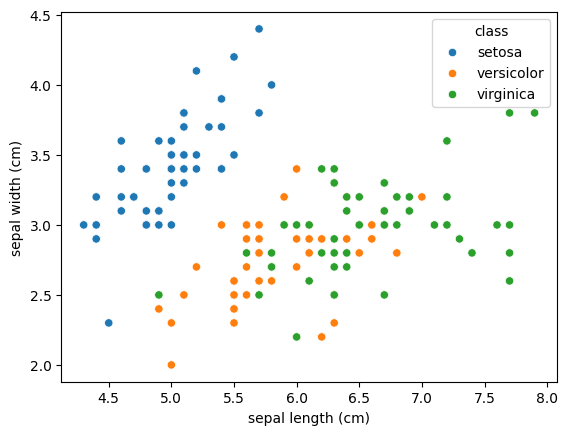

In [2]:
import seaborn as sns
import pandas as pd
from sklearn import datasets

# Get data
iris = datasets.load_iris(as_frame=True)

df = iris.frame
df['class'] = pd.Categorical.from_codes(iris.target, iris.target_names)

sns.scatterplot(data=df, x="sepal length (cm)", y="sepal width (cm)", hue="class");

In the plot, you can already see that the Setosa species stands out clearly — it tends to have shorter and wider sepals, making it easily distinguishable. However, Versicolor and Virginica show more overlap, making them harder to separate using only these two dimensions.


The question is: Given a **new data point** with certain sepal measurements, how can we decide which iris species **it belongs to**? This is the kind of problem that a classification algorithm like kNN is designed to solve. 


Let's first prepare our dataset:

In [3]:
X = df[["sepal length (cm)", "sepal width (cm)"]]
y = df["class"]

When training a kNN classifier, it's important to normalize the features. This is because kNN relies on distance calculations, and unscaled features can distort the results. The `StandardScaler` from `sklearn` standardizes features by removing the mean and scaling them to unit variance:

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## KNN Classifier Implementation

```{margin}
k is the number of nearest neighbors to use and is a hyperparameter
```

The choice of $k$ plays a crucial role:
- A small $k$ (e.g., 1) makes the method sensitive to noise and outliers.
- A larger $k$ smooths the decision boundary, possibly at the cost of ignoring finer local structures.


As with all hyperparameters, there is no magical formula to determine the best value for $k$ in advance. Instead, we need to try out a range of values and use our best judgment to choose the one that works best.

To do this, we’ll fit the k-Nearest Neighbors model using different $k$-values within a specified range. To evaluate which value performs best, we here use 5-fold cross validation.

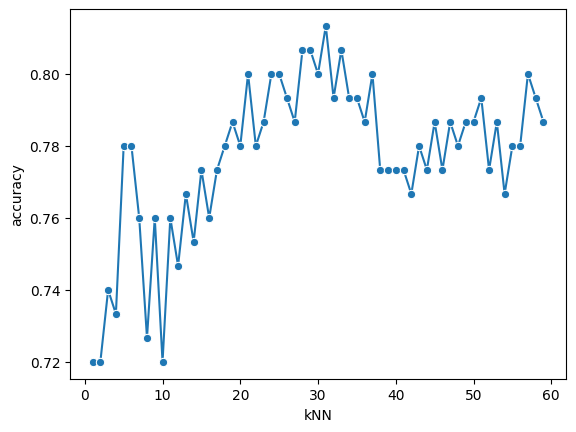

In [5]:
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_range = range(1, 60)
accuracies = []

# Loop over all k values and save the accuracy
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracy = cross_val_score(knn, X_scaled, y, cv=5)
    accuracies.append(np.mean(accuracy))

# Plot
fig, ax = plt.subplots()
sns.lineplot(x = k_range, y = accuracies, marker = 'o', ax=ax)
ax.set(xlabel="kNN", ylabel="accuracy");

In [6]:
best_index = np.argmax(accuracies)
best_k, best_accuracy = k_range[best_index], accuracies[best_index]

print(f"Best k: {best_k}")
print(f"Accuracy: {best_accuracy:.2f}")

Best k: 31
Accuracy: 0.81


Let's visualise the decision boundary:

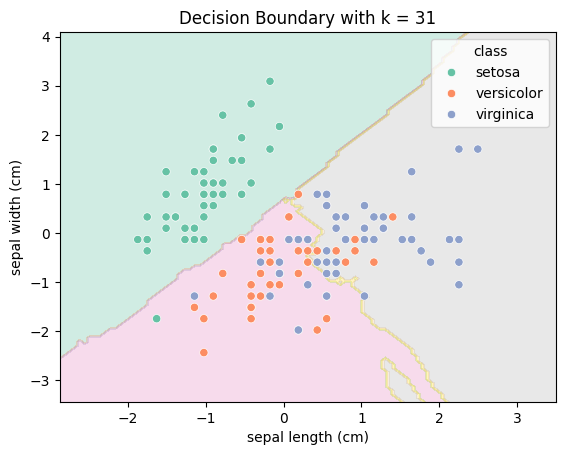

In [7]:
# Create a DataFrame with the scaled features and the target
df_scaled = pd.DataFrame(X_scaled, columns=["sepal length (cm)", "sepal width (cm)"])
df_scaled['class'] = df['class']

# Fit the KNN classifier
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_scaled, df['target'])

# Generate mesh grid for predicting and plotting the decision boundary
x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot
fig, ax = plt.subplots()
ax.contourf(xx, yy, Z, alpha=0.3, cmap="Set2")
sns.scatterplot(data=df_scaled, x="sepal length (cm)", y="sepal width (cm)", hue="class", palette='Set2', ax=ax)
ax.set(xlabel=df_scaled.columns[0], ylabel=df_scaled.columns[1], title=f"Decision Boundary with k = {best_k}");

In [8]:
from jupyterquiz import display_quiz
display_quiz("quiz/KNN.json", shuffle_answers=True)

<IPython.core.display.Javascript object>

```{admonition} The choice of k
:class: note 

In datasets where class boundaries are clear and the data is clean, a higher $k$ can be beneficial. It provides a form of regularization by averaging over many neighbors. In contrast, for more complex or noisy datasets, a high $k$ could oversimplify the structure and reduce model performance.
```